In [18]:
# %%
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, LineString
import geopandas as gpd

%matplotlib inline

# Funció per trobar node més proper (ja la teníem)
def find_nearest_node(graph, point):
    """Troba el node més proper a un punt (x, y) en el graf projectat"""
    nodes = list(graph.nodes())
    node_coords = np.array([(graph.nodes[n]['x'], graph.nodes[n]['y']) for n in nodes])
    
    distances = np.sqrt((node_coords[:, 0] - point[0])**2 + 
                       (node_coords[:, 1] - point[1])**2)
    
    nearest_idx = np.argmin(distances)
    nearest_node = nodes[nearest_idx]
    distance = distances[nearest_idx]
    
    return nearest_node, distance

# Carreguem la xarxa
print("Carregant xarxa de Barcelona...")
area = "Eixample, Barcelona, Spain"  # Zona amb grid regular
G = ox.graph_from_place(area, network_type='walk', simplify=True)
G_proj = ox.project_graph(G)

print(f"✅ Xarxa carregada: {len(G.nodes())} nodes, {len(G.edges())} vores")

Carregant xarxa de Barcelona...
✅ Xarxa carregada: 7490 nodes, 24174 vores


In [19]:
# %%
# Definim punts per dibuixar una lletra "A" majúscula
# Coordenades relatives (0-1) que després escalarem

# Camí per dibuixar la "A": 
# 1. Esquerra inferior -> Punt superior -> Dreta inferior
# 2. Barra horitzontal

# Punts principals de la "A"
points_A_relative = [
    (0.0, 0.0),   # Peu esquerra
    (0.4, 1.0),   # Punt superior esquerra (no exactament al centre)
    (0.6, 1.0),   # Punt superior dreta
    (1.0, 0.0),   # Peu dret
    (0.8, 0.4),   # Barra horitzontal dreta
    (0.2, 0.4),   # Barra horitzontal esquerra
    (0.0, 0.0),   # Tancar el camí (tornar a inici)
]

# Convertim a array numpy
points_A_relative = np.array(points_A_relative)

# Centre i dimensió de la zona on dibuixarem
center_x, center_y = np.array([(G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) 
                              for n in G_proj.nodes()]).mean(axis=0)

# Dimensions màximes que ocuparà la lletra (en metres)
width_m = 1000   # Amplada màxima
height_m = 1000  # Alçada màxima

# Escalem i traslladem els punts
points_A_scaled = []
for x_rel, y_rel in points_A_relative:
    x_abs = center_x + (x_rel - 0.5) * width_m
    y_abs = center_y + (y_rel - 0.5) * height_m
    points_A_scaled.append((x_abs, y_abs))

points_A_scaled = np.array(points_A_scaled)

print(f"Centre: ({center_x:.0f}, {center_y:.0f})")
print(f"Dimensió: {width_m}x{height_m} metres")
print(f"Punts de la 'A': {len(points_A_scaled)}")

Centre: (430151, 4582572)
Dimensió: 1000x1000 metres
Punts de la 'A': 7


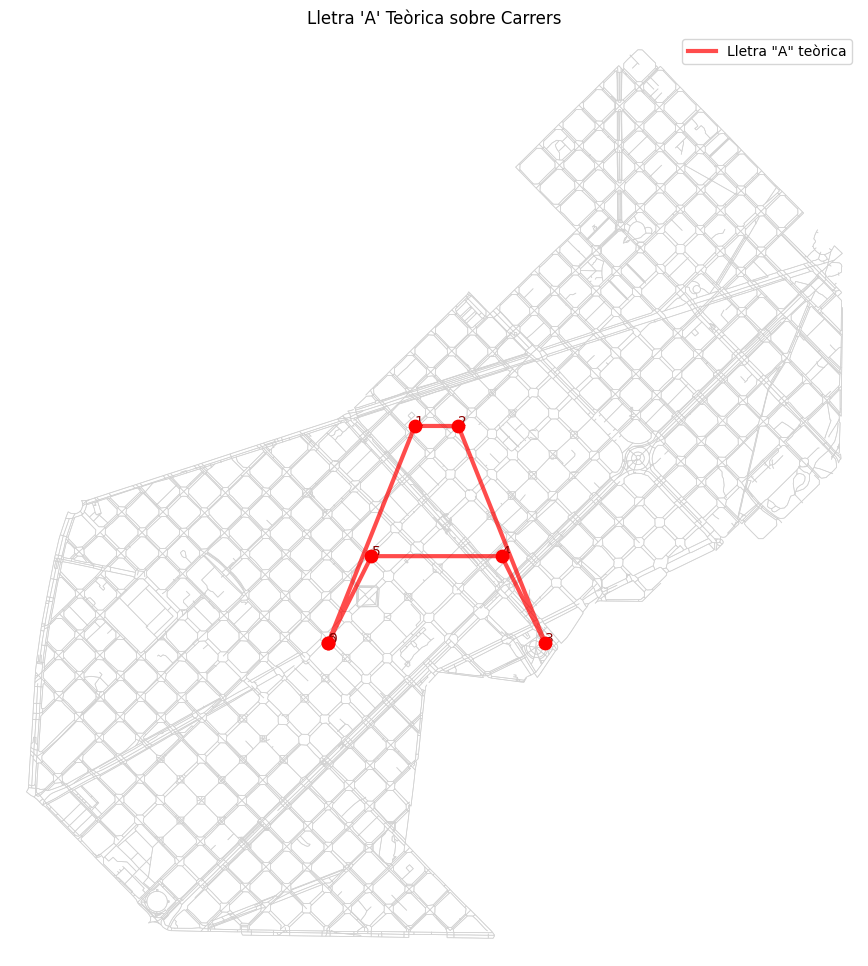

In [20]:
# %%
# Visualitzem la "A" teòrica sobre el mapa de carrers
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(G_proj, node_size=0, edge_linewidth=0.5, ax=ax, show=False, edge_color='lightgray')

# Dibuixem la "A" teòrica
ax.plot(points_A_scaled[:, 0], points_A_scaled[:, 1], 
        'r-', linewidth=3, alpha=0.7, label='Lletra "A" teòrica')

# Marquem els punts
ax.scatter(points_A_scaled[:, 0], points_A_scaled[:, 1], 
           color='red', s=80, zorder=5)

# Anotem els punts
for i, (x, y) in enumerate(points_A_scaled):
    ax.annotate(str(i), (x, y), fontsize=10, color='darkred')

ax.legend()
ax.set_title("Lletra 'A' Teòrica sobre Carrers")
plt.show()

Buscant nodes més propers per cada punt...
Distància mitjana al carrer més proper: 14.2 m
Màxima distància: 30.7 m


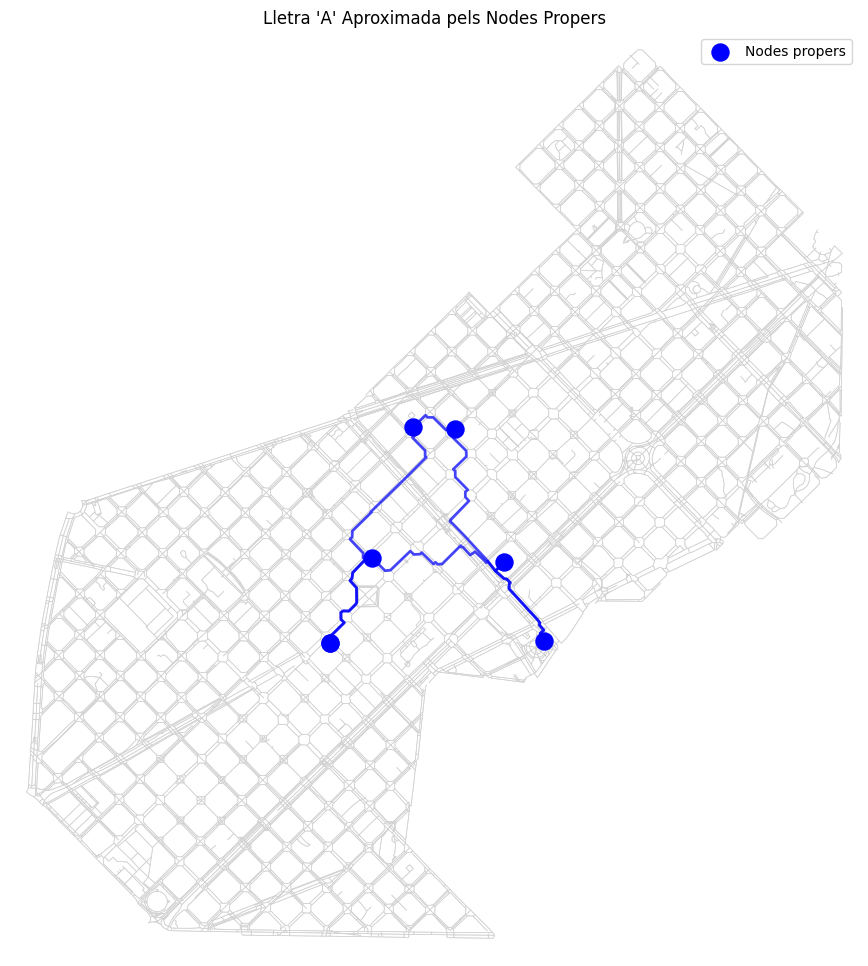

In [21]:
# %%
# Trobar el node més proper per a cada punt de la "A"
A_nodes = []
A_distances = []

print("Buscant nodes més propers per cada punt...")
for point in points_A_scaled:
    node, dist = find_nearest_node(G_proj, point)
    A_nodes.append(node)
    A_distances.append(dist)

print(f"Distància mitjana al carrer més proper: {np.mean(A_distances):.1f} m")
print(f"Màxima distància: {np.max(A_distances):.1f} m")

# Visualitzem els nodes trobats
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(G_proj, node_size=0, edge_linewidth=0.5, ax=ax, show=False, edge_color='lightgray')

# Nodes trobats
node_coords = [(G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in A_nodes]
node_coords = np.array(node_coords)

ax.scatter(node_coords[:, 0], node_coords[:, 1], 
           color='blue', s=150, label='Nodes propers', zorder=5)

# Connectem els nodes en l'ordre de la "A"
for i in range(len(A_nodes)-1):
    node1 = A_nodes[i]
    node2 = A_nodes[i+1]
    
    try:
        path = nx.shortest_path(G_proj, node1, node2, weight='length')
        path_coords = [(G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in path]
        path_coords = np.array(path_coords)
        ax.plot(path_coords[:, 0], path_coords[:, 1], 'b-', linewidth=2, alpha=0.7)
    except nx.NetworkXNoPath:
        print(f"⚠️ No hi ha camí entre punt {i} i {i+1}")

ax.legend()
ax.set_title("Lletra 'A' Aproximada pels Nodes Propers")
plt.show()

In [22]:
# %%
# Construïm la ruta completa de la "A"
route_A = []
total_distance = 0
problems = []

for i in range(len(A_nodes)-1):
    node1 = A_nodes[i]
    node2 = A_nodes[i+1]
    
    try:
        # Camí més curt entre els nodes
        path = nx.shortest_path(G_proj, node1, node2, weight='length')
        distance = nx.shortest_path_length(G_proj, node1, node2, weight='length')
        
        # Afegim a la ruta (evitant duplicar el node inicial)
        if not route_A:
            route_A.extend(path)
        else:
            # Si l'últim node ja és el primer del nou camí, no el dupliquem
            if route_A[-1] == path[0]:
                route_A.extend(path[1:])
            else:
                route_A.extend(path)
        
        total_distance += distance
        
    except nx.NetworkXNoPath:
        problems.append((i, i+1))
        print(f"❌ No hi ha camí entre punts {i} i {i+1}")

print(f"✅ Ruta construïda amb {len(route_A)} nodes")
print(f"📏 Distància total aproximada: {total_distance:.0f} m ({total_distance/1000:.2f} km)")

if problems:
    print(f"⚠️ Problemes en {len(problems)} segments")

✅ Ruta construïda amb 155 nodes
📏 Distància total aproximada: 4772 m (4.77 km)


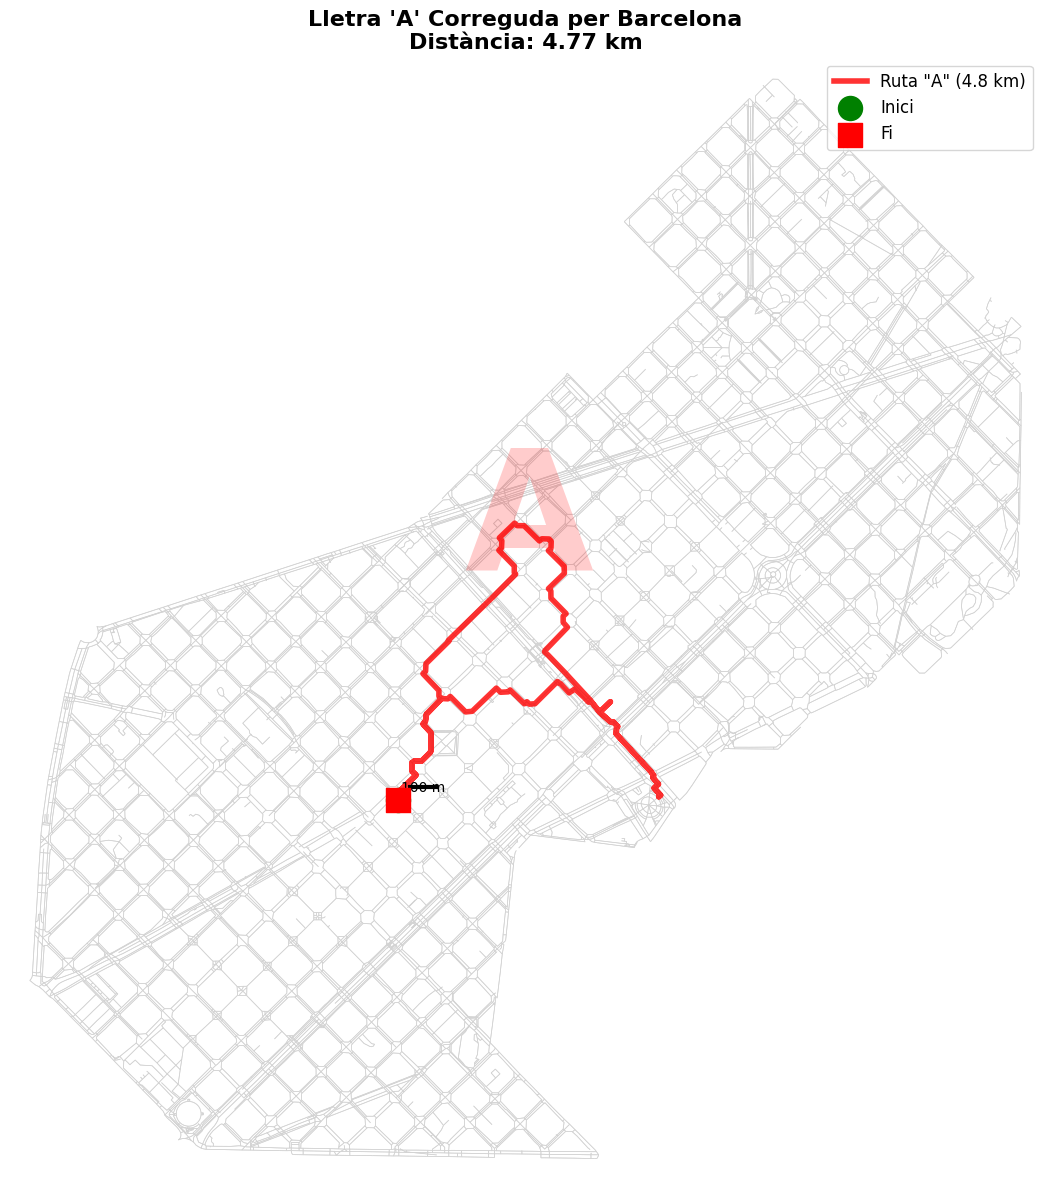

In [23]:
# %%
# Visualització final de la ruta de la "A"
fig, ax = plt.subplots(figsize=(14, 12))

# Carrers de fons
ox.plot_graph(G_proj, node_size=0, edge_linewidth=0.5, ax=ax, show=False, 
              edge_color='lightgray', bgcolor='white')

# Ruta de la "A"
if route_A:
    route_coords = [(G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in route_A]
    route_coords = np.array(route_coords)
    
    # Dibuixem la ruta
    ax.plot(route_coords[:, 0], route_coords[:, 1], 
            'r-', linewidth=4, alpha=0.8, label=f'Ruta "A" ({total_distance/1000:.1f} km)')
    
    # Punts d'inici/fi
    ax.scatter(route_coords[0, 0], route_coords[0, 1], 
               color='green', s=300, marker='o', label='Inici', zorder=10)
    ax.scatter(route_coords[-1, 0], route_coords[-1, 1], 
               color='red', s=300, marker='s', label='Fi', zorder=10)
    
    # Anotem la lletra
    ax.text(center_x, center_y + height_m/2 + 50, 'A', 
            fontsize=120, fontweight='bold', 
            color='red', alpha=0.2, ha='center', va='center')

# Afegim informació al gràfic
ax.legend(fontsize=12)
ax.set_title(f"Lletra 'A' Correguda per Barcelona\nDistància: {total_distance/1000:.2f} km", 
             fontsize=16, fontweight='bold')

# Afegim escala
scale_x = center_x - width_m/2 + 50
scale_y = center_y - height_m/2 + 50
ax.plot([scale_x, scale_x + 100], [scale_y, scale_y], 'k-', linewidth=3)
ax.text(scale_x + 50, scale_y - 20, '100 m', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [24]:
# %%
# Anàlisi de què tan bé s'assembla al dibuix original

def calculate_similarity(original_points, route_points):
    """Calcula semblança entre la forma original i la ruta"""
    # Simplificació: distància mitjana dels punts de la ruta a la forma original
    from scipy.spatial import KDTree
    
    # Creem un arbre KD de la forma original per trobar punts propers
    tree = KDTree(original_points)
    
    # Mostrejem la ruta uniformement
    n_samples = min(100, len(route_points))
    sample_indices = np.linspace(0, len(route_points)-1, n_samples, dtype=int)
    route_samples = route_points[sample_indices]
    
    # Distància de cada punt mostrejat a la forma original
    distances, _ = tree.query(route_samples)
    
    return np.mean(distances), np.max(distances)

if len(route_A) > 10:
    route_coords_array = np.array([(G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in route_A])
    
    mean_dist, max_dist = calculate_similarity(points_A_scaled, route_coords_array)
    
    print("📊 ANÀLISI DE QUALITAT:")
    print(f"  Distància mitjana a la forma ideal: {mean_dist:.1f} m")
    print(f"  Màxima desviació: {max_dist:.1f} m")
    print(f"  Longitud de ruta: {total_distance:.0f} m")
    print(f"  Densitat de punts: {len(route_A)} punts ({len(route_A)/total_distance*1000:.1f} punts/km)")
    
    # Anàlisi d'eficiència
    # Longitud mínima possible (distància directa entre punts)
    min_possible = 0
    for i in range(len(points_A_scaled)-1):
        min_possible += np.linalg.norm(points_A_scaled[i+1] - points_A_scaled[i])
    
    efficiency = min_possible / total_distance if total_distance > 0 else 0
    print(f"  Eficiència (distància ideal/real): {efficiency:.2%}")
    
    # Classificació de qualitat
    if mean_dist < 50:
        print("  ✅ Qualitat: Bona (la forma es reconeix bé)")
    elif mean_dist < 100:
        print("  ⚠️ Qualitat: Acceptable (es reconeix la forma)")
    else:
        print("  ❌ Qualitat: Pobra (la forma està massa distorsionada)")

📊 ANÀLISI DE QUALITAT:
  Distància mitjana a la forma ideal: 131.3 m
  Màxima desviació: 320.1 m
  Longitud de ruta: 4772 m
  Densitat de punts: 155 punts (32.5 punts/km)
  Eficiència (distància ideal/real): 80.66%
  ❌ Qualitat: Pobra (la forma està massa distorsionada)


In [17]:
# %%
try:
    import gpxpy
    import gpxpy.gpx
    
    # Convertim els nodes de la ruta a coordenades geogràfiques
    route_coords_geo = []
    for node in route_A:
        lat = G.nodes[node]['y']  # Atenció: OSMnx guarda com y=lat, x=lon
        lon = G.nodes[node]['x']
        route_coords_geo.append((lat, lon))
    
    # Creem el fitxer GPX
    gpx = gpxpy.gpx.GPX()
    
    # Creem una track
    gpx_track = gpxpy.gpx.GPXTrack()
    gpx.tracks.append(gpx_track)
    
    # Creem un segment
    gpx_segment = gpxpy.gpx.GPXTrackSegment()
    gpx_track.segments.append(gpx_segment)
    
    # Afegim punts
    for lat, lon in route_coords_geo:
        gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(lat, lon))
    
    # Guardem
    gpx_filename = "ruta_letra_A_barcelona.gpx"
    with open(gpx_filename, 'w') as f:
        f.write(gpx.to_xml())
    
    print(f"✅ GPX exportat: {gpx_filename}")
    print(f"   - Punts: {len(route_coords_geo)}")
    print(f"   - Distància: {total_distance/1000:.2f} km")
    
    # Informació per l'usuari
    print("\n📱 Com provar-ho:")
    print("1. Descarrega el fitxer GPX")
    print("2. Puja-lo a Strava, Garmin Connect, komoot, etc.")
    print("3. O obre-lo amb Google Earth per veure la ruta")
    
except ImportError:
    print("Instal·la gpxpy: pip install gpxpy")
    
    # Mostrem coordenades de mostra
    print("\nPrimers 5 punts de la ruta (lat, lon):")
    for i, node in enumerate(route_A[:5]):
        lat = G.nodes[node]['y']
        lon = G.nodes[node]['x']
        print(f"  {i}: {lat:.6f}, {lon:.6f}")

✅ GPX exportat: ruta_letra_A_barcelona.gpx
   - Punts: 169
   - Distància: 5.19 km

📱 Com provar-ho:
1. Descarrega el fitxer GPX
2. Puja-lo a Strava, Garmin Connect, komoot, etc.
3. O obre-lo amb Google Earth per veure la ruta


Provant amb 'A' de major resolució...
Densa: 199 nodes, 5.34 km


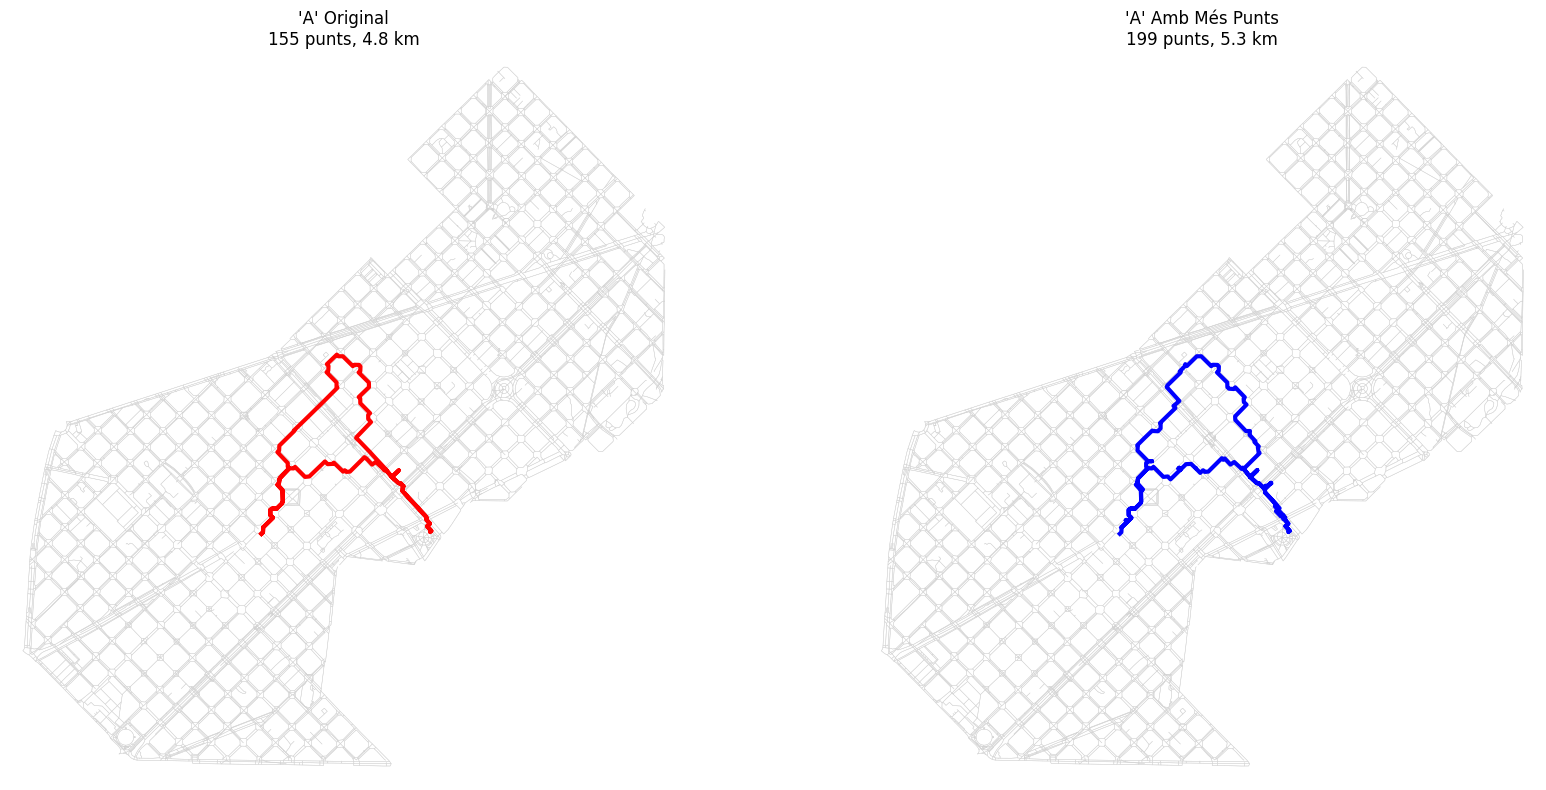

In [25]:
# %%
# Provem amb una "A" definida amb més punts per major precisió
print("Provant amb 'A' de major resolució...")

# Definim la "A" amb interpolació lineal entre punts
def interpolate_points(points, n_points_per_segment=20):
    """Interpola punts entre els punts definits"""
    interpolated = []
    
    for i in range(len(points)-1):
        start = points[i]
        end = points[i+1]
        
        # Genera punts intermedis
        for j in range(n_points_per_segment):
            t = j / n_points_per_segment
            x = start[0] + (end[0] - start[0]) * t
            y = start[1] + (end[1] - start[1]) * t
            interpolated.append([x, y])
    
    return np.array(interpolated)

# Interpolem la "A" original
points_A_dense = interpolate_points(points_A_scaled, n_points_per_segment=15)

# Mapejem als carrers
A_nodes_dense = []
for point in points_A_dense:
    node, _ = find_nearest_node(G_proj, point)
    A_nodes_dense.append(node)

# Construïm ruta
route_A_dense = []
total_distance_dense = 0

for i in range(len(A_nodes_dense)-1):
    node1 = A_nodes_dense[i]
    node2 = A_nodes_dense[i+1]
    
    try:
        path = nx.shortest_path(G_proj, node1, node2, weight='length')
        distance = nx.shortest_path_length(G_proj, node1, node2, weight='length')
        
        if not route_A_dense:
            route_A_dense.extend(path)
        else:
            if route_A_dense[-1] == path[0]:
                route_A_dense.extend(path[1:])
            else:
                route_A_dense.extend(path)
        
        total_distance_dense += distance
    except:
        pass

print(f"Densa: {len(route_A_dense)} nodes, {total_distance_dense/1000:.2f} km")

# Visualització comparativa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Original
ox.plot_graph(G_proj, node_size=0, edge_linewidth=0.3, ax=ax1, show=False, edge_color='lightgray')
if route_A:
    coords = np.array([(G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in route_A])
    ax1.plot(coords[:, 0], coords[:, 1], 'r-', linewidth=3)
ax1.set_title(f"'A' Original\n{len(route_A)} punts, {total_distance/1000:.1f} km")

# Densa
ox.plot_graph(G_proj, node_size=0, edge_linewidth=0.3, ax=ax2, show=False, edge_color='lightgray')
if route_A_dense:
    coords_dense = np.array([(G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in route_A_dense])
    ax2.plot(coords_dense[:, 0], coords_dense[:, 1], 'b-', linewidth=3)
ax2.set_title(f"'A' Amb Més Punts\n{len(route_A_dense)} punts, {total_distance_dense/1000:.1f} km")

plt.tight_layout()
plt.show()

Provant amb lletra 'B'...


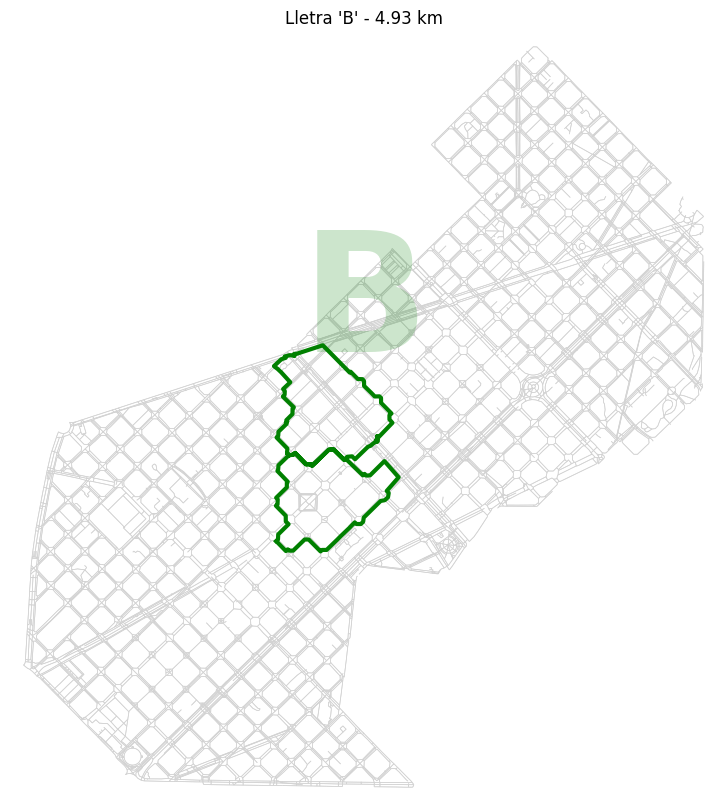

In [26]:
# %%
# Definició ràpida d'una "B"
print("Provant amb lletra 'B'...")

# Punts per una "B" simple
points_B_relative = [
    (0.0, 0.0),   # Inferior esquerra
    (0.0, 1.0),   # Superior esquerra
    (0.6, 0.8),   # Corba superior dreta
    (0.6, 0.6),   # Mig dreta superior
    (0.0, 0.5),   # Esquerra mig
    (0.6, 0.4),   # Mig dreta inferior
    (0.6, 0.2),   # Corba inferior dreta
    (0.0, 0.0),   # Tancar
]

# Escalar
points_B_scaled = []
for x_rel, y_rel in points_B_relative:
    x_abs = center_x + (x_rel - 0.5) * width_m
    y_abs = center_y + (y_rel - 0.5) * height_m
    points_B_scaled.append((x_abs, y_abs))

points_B_scaled = np.array(points_B_scaled)

# Mapejar i generar ruta
B_nodes = []
for point in points_B_scaled:
    node, _ = find_nearest_node(G_proj, point)
    B_nodes.append(node)

# Construir ruta
route_B = []
total_distance_B = 0

for i in range(len(B_nodes)-1):
    try:
        path = nx.shortest_path(G_proj, B_nodes[i], B_nodes[i+1], weight='length')
        dist = nx.shortest_path_length(G_proj, B_nodes[i], B_nodes[i+1], weight='length')
        
        if not route_B:
            route_B.extend(path)
        else:
            if route_B[-1] == path[0]:
                route_B.extend(path[1:])
            else:
                route_B.extend(path)
        
        total_distance_B += dist
    except:
        pass

# Visualització
fig, ax = plt.subplots(figsize=(12, 10))
ox.plot_graph(G_proj, node_size=0, edge_linewidth=0.5, ax=ax, show=False, edge_color='lightgray')

if route_B:
    coords_B = np.array([(G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in route_B])
    ax.plot(coords_B[:, 0], coords_B[:, 1], 'g-', linewidth=3)
    ax.text(center_x, center_y + height_m/2 + 50, 'B', 
            fontsize=120, fontweight='bold', color='green', alpha=0.2, ha='center')

ax.set_title(f"Lletra 'B' - {total_distance_B/1000:.2f} km")
plt.show()